## Analyze A/B Test Results


This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.



<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [2]:
#importing all the libraries needed

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [3]:
df = pd.read_csv('ab_data.csv')

df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [4]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [5]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [6]:
# showthe propotion using the mean
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [9]:
df.query("landing_page == 'new_page' and group != 'treatment'").shape[0]+df.query("landing_page != 'new_page' and group == 'treatment'").shape[0]

3893

f. Do any of the rows have missing values?

In [10]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [13]:
# with this cell all the pages that don't match will be retured 
dont_match = df.query("landing_page != 'new_page' and group == 'treatment' "+
                      "or landing_page == 'new_page' and group != 'treatment'").index.values
dont_match.shape[0]

3893

In [14]:
# here is the drop of the don't match pages
df2 = df.drop(dont_match) 

In [16]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [17]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [18]:
df2[df2.duplicated(subset='user_id')].user_id

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [19]:
# make sure there is repeated use-id
df2.duplicated(subset='user_id', keep=False).sum()

2

In [20]:
df2[df2.duplicated(subset='user_id', keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [21]:
# here the oldest will be drop
df2.drop(1899, inplace=True)

In [22]:
# make sure there is no repeated use-id
df2.duplicated(subset='user_id', keep=False).sum()

0

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [23]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [24]:
control = df2.query('group == "control"')['converted'].mean()

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [25]:
treatment = df2.query('group == "treatment"')['converted'].mean()

d. What is the probability that an individual received the new page?

In [26]:
#Probability of a user landing on new_page
df2.query('landing_page == "new_page"').count()[0]/df2.shape[0] 

0.50006194422266881

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**there are no Sufficient evidence to think the new treatment page leades to mare coversions, but that new treatment page 11.8% of conversions and control page 12% of conversions, which means that the treatment page dose leads to less conversions than the cotrol page by 0.2% only.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Answer:**
<div style="text-align: center;">
<br>
$H_{0}$ :   $p_{old}$ > $p_{new}$
<br><br>
$H_{1}$ : $p_{old}$ < $p_{new}$
</div>

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? <br><br>

In [27]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [28]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

 the conversion rate under the null for both is the same

c. What is $n_{new}$, the number of individuals in the treatment group?

In [29]:
n_new = df2.query('landing_page == "new_page"').count()[0]
n_new   

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [30]:
n_old = df2.query('landing_page == "old_page"').count()[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [31]:
new_page_converted = np.random.binomial(1, p_new, n_new)

new_page_converted.mean()

0.12026013350767326

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [32]:
old_page_converted = np.random.binomial(1, p_old, n_old)

old_page_converted.mean()

0.12179054751710561

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [33]:
#diffence btween the new and old prapbaiaty 

diffence = new_page_converted.mean() - old_page_converted.mean()

diffence

-0.0015304140094323515

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [35]:
p_diffs = []
new_convert = np.random.binomial(n_new, p_new, 10000)/n_new
old_convert = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_convert - old_convert

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

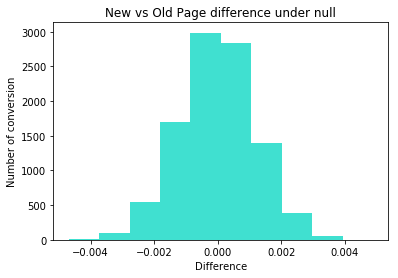

In [36]:
plt.hist(p_diffs, color='Turquoise');
plt.title('New vs Old Page difference under null');
plt.xlabel('Difference');
plt.ylabel('Number of conversion');
plt.legend();

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

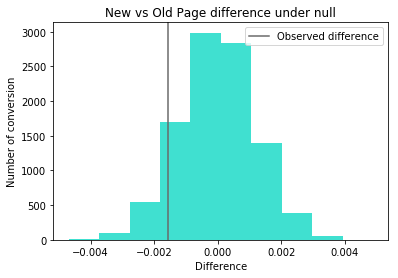

In [37]:
# Geting the observed difference from the control, and treatment group 
observed_diff = treatment - control

#Plot shows proportion of the p_diffs greater than the observed difference 
plt.title('New vs Old Page difference under null');
plt.xlabel('Difference');
plt.ylabel('Number of conversion');
plt.hist(p_diffs, color='Turquoise');
plt.axvline(observed_diff, color='DimGrey',label = "Observed difference");
plt.legend();

In [38]:
# the p_diffs are greater than the actual difference observed by
(p_diffs > observed_diff).mean()

0.90659999999999996

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer.**
<div style="text-align: center;">
<br>
$H_{0}$ : $p_{new}$ - $p_{old}$ ≤ 0
<br>
<br>
$H_{1}$ : $p_{new}$ - $p_{old}$ > 0
</div>


**The alpha is 5% , if the p value is under the alpha level the null hypothesis should be rejected, the p value is equal 90% which that suggests that I failed to reject the null-hypothesis of the covertion rate of new page the same or worse than the old page. so there is no statistically significant.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [40]:
# getting the numbers of the coverted pages the old and the new 
#and the number of pages the old and the new

convert_old =  df2.query("landing_page == 'old_page' and converted == 1").count()[0]
convert_new = df2.query("landing_page == 'new_page' and converted == 1").count()[0] 
n_old = df2.query("landing_page == 'old_page'").count()[0]
n_new = df2.query("landing_page == 'new_page'").count()[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [41]:
#getting the z_score, p_value 
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new,n_old], alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**the z-score computed is the standard deviations from the mean, when the p valueis more then 5% we can't reject the null hypothsis and my pvalue is 90.5%.
<br>They agree with the findings of quotation j an k but different values so it is still no statistically significant between the covertion rates.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**The Logistic Regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [42]:
#create intercept column it hold value 1 
df2['intercept'] = 1

In [43]:
# ab_page 1 is equal to treatment from cloumn group 
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [44]:
#using the Fitting model using the new colums intercept and ab_page
model = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [45]:
#sammary of the reults
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 09 Nov 2019   Pseudo R-squ.:               8.077e-06
Time:                        00:38:44   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**the p-value by the ab_page is 19%, the p_value is so differnt than the p_value that is z-score, but is more than 5% 'Alpha Level' once again I have failed to reject the null hypothesis.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Definiteley having other factors is a good idea becuse that will make the result more reliable.
disadvantages like outliiers or error, and regression model would look messy.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [46]:
#read the data from countries.csv
df_countries = pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [47]:
#join the dataframs df2 and df_countries with index as user_id

df3 = df_countries.set_index('user_id').join(df2.set_index('user_id'))
df3.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [48]:
# finding all the country uerse are from
df_countries['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [49]:
# create dummies for the necessary variables
df3[['US', 'UK', 'CA']] = pd.get_dummies(df3['country'])[['US', "UK", 'CA']]
df3.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK,CA
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [50]:
df3['UK_ab_page'] = df3['UK']*df3['ab_page']
df3['US_ab_page'] = df3['US']*df3['ab_page']
df3['CA_ab_page'] = df3['CA']*df3['ab_page']
df3.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK,CA,UK_ab_page,US_ab_page,CA_ab_page
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,1,0,0,0,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,1,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,1,0,0


In [51]:
# the rationship between varbiels
model1 = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'US', 'UK', 'CA','US_ab_page', 'UK_ab_page', 'CA_ab_page']])
result1 = model1.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 31


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [53]:
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sat, 09 Nov 2019   Pseudo R-squ.:               3.482e-05
Time:                        00:39:21   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.4957   2.03e+05  -7.35e-06      1.000   -3.99e+05    3.99e+05
ab_page       -0.0193   3.83e+05  -5.03e-08      1.000   -7.51e+05    7.51e+05
US            -0.4908   2.03e+05  -2.41e-06      1.000   -3.99e+05    3.99e+05
UK            -0.4965   2.03e+05  -2.44e-06      1.000   -3.99e+05    3.99e+05
CA            -0.5083   2.03e+05   -2.5e-06      1.000   -3.99e+05    3.99e+05
US_ab_page    -0.0013   3.83e+05  -3.31e-09      1.000   -7.51e+05    7.51e+05
UK_ab_page     0.0301   3.83e+05   7.86e-08      1.000   -7.51e+05    7.51e+05
CA_ab_page    -0.0482   3.83e+05  -1.26e-07      1.000   -7.51e+05    7.51e+05
==============================================================================
"""

<a id='conclusions'></a>





## Conclusions
> in partII and partIII the values of p_value changed but I failed to reject the Null.
different countries also didn't show significance diffrence.  
there is no practical significance in the conversion rate that would indicate that the old page is better than the new page.




In [54]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0